In [2]:
! pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np

In [3]:


# Load dataset
df = pd.read_csv("final_model_dataset_with_features.csv")

# Target and features
X = df.drop(columns=['cases'])  # All columns except target
y = df['cases']

# Categorical and numeric handling
categorical_features = ['state']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Evaluation function
def evaluate_model(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
rf_metrics = evaluate_model(y_test, y_pred_rf)

# Optimized XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=30,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
xgb_metrics = evaluate_model(y_test, y_pred_xgb)

# Show results
print("Random Forest Metrics:", rf_metrics)
print("XGBoost Metrics:", xgb_metrics)


Random Forest Metrics: {'RMSE': 20.771411022677682, 'MAE': 6.408412698412698, 'R2': 0.6683444625918167}
XGBoost Metrics: {'RMSE': 22.454905184289032, 'MAE': 7.2899277565025145, 'R2': 0.6124054116025923}


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


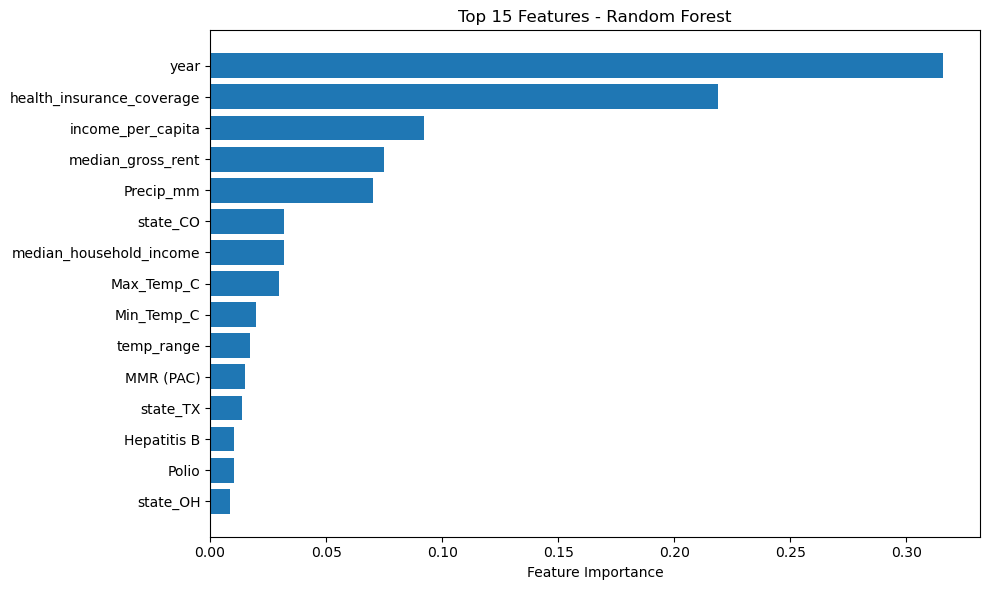

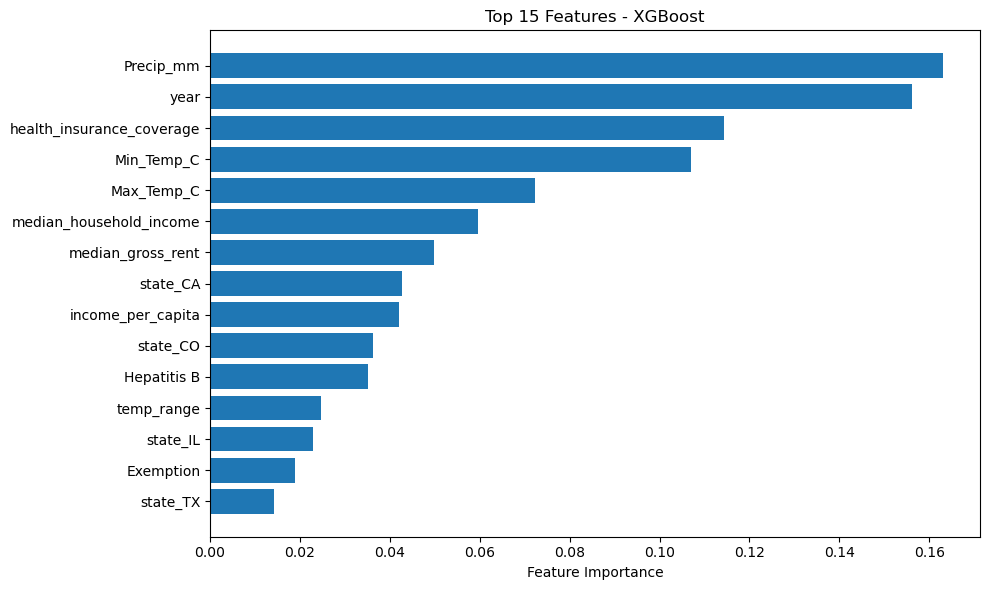

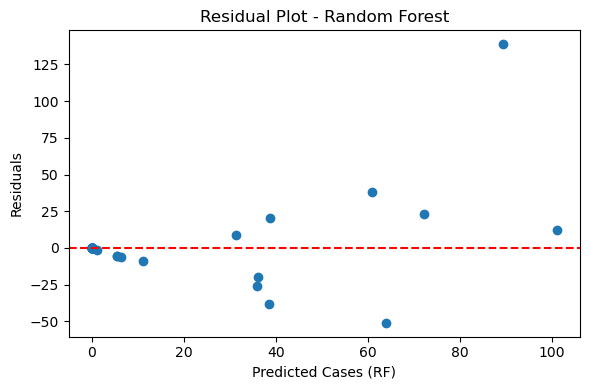

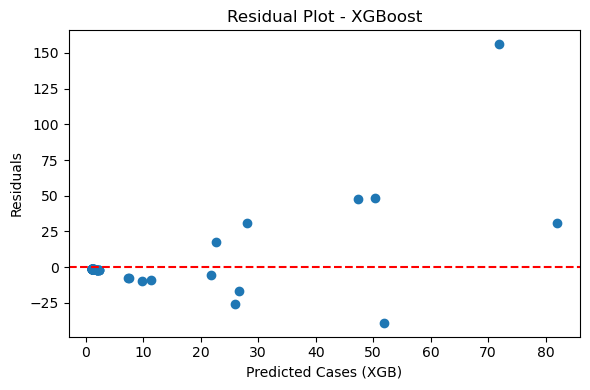

In [4]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
# ---------------------------
# GridSearchCV for both models
# ---------------------------
# Fast Grid for XGBoost
xgb_param_grid = {
    'regressor__n_estimators': [20],
    'regressor__max_depth': [2, 3],
    'regressor__learning_rate': [0.1]
}

# Small grid for Random Forest
rf_param_grid = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': [None, 10]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
xgb_grid.fit(X_train, y_train)

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
rf_grid.fit(X_train, y_train)

# ---------------------------
# Feature Importance
# ---------------------------
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['state'])
numeric_features = X.drop(columns=['state']).columns
all_feature_names = np.concatenate([encoded_feature_names, numeric_features])

# Random Forest
rf_best_model = rf_grid.best_estimator_.named_steps['regressor']
rf_importances = rf_best_model.feature_importances_
rf_sorted_idx = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(all_feature_names[rf_sorted_idx][:15][::-1], rf_importances[rf_sorted_idx][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features - Random Forest")
plt.tight_layout()
plt.show()

# XGBoost
xgb_best_model = xgb_grid.best_estimator_.named_steps['regressor']
xgb_importances = xgb_best_model.feature_importances_
xgb_sorted_idx = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(all_feature_names[xgb_sorted_idx][:15][::-1], xgb_importances[xgb_sorted_idx][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features - XGBoost")
plt.tight_layout()
plt.show()

# ---------------------------
# Residual Analysis
# ---------------------------
rf_preds = rf_grid.predict(X_test)
xgb_preds = xgb_grid.predict(X_test)

rf_residuals = y_test - rf_preds
xgb_residuals = y_test - xgb_preds

# Random Forest Residuals
plt.figure(figsize=(6, 4))
plt.scatter(rf_preds, rf_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Cases (RF)")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.tight_layout()
plt.show()

# XGBoost Residuals
plt.figure(figsize=(6, 4))
plt.scatter(xgb_preds, xgb_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Cases (XGB)")
plt.ylabel("Residuals")
plt.title("Residual Plot - XGBoost")
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset
df = pd.read_csv("final_model_dataset_with_features.csv")

# Define target and features
y = df["cases"]
X = df.drop(columns=["cases"])

# Categorical encoding
categorical_features = ["state"]
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])
xgb_pipeline.fit(X_train, y_train)

# Add predictions to the original DataFrame
df["rf_pred"] = rf_pipeline.predict(X)
df["xgb_pred"] = xgb_pipeline.predict(X)

# Aggregate predictions by state-year
agg = df.groupby(["state", "year"]).agg({
    "cases": "sum",
    "rf_pred": "sum",
    "xgb_pred": "sum"
}).reset_index()

# Evaluate model performance
print(" Evaluation by State-Year Aggregates:")
for model in ["rf_pred", "xgb_pred"]:
    print(f"\n {model.upper()} Metrics:")
    print("MAE :", mean_absolute_error(agg["cases"], agg[model]))
    print("RMSE:", np.sqrt(mean_squared_error(agg["cases"], agg[model])))
    print("R²  :", r2_score(agg["cases"], agg[model]))


 Evaluation by State-Year Aggregates:

 RF_PRED Metrics:
MAE : 3.4650482315112545
RMSE: 12.598104269679252
R²  : 0.8742405905612416

 XGB_PRED Metrics:
MAE : 3.505842076297071
RMSE: 11.879659609275608
R²  : 0.8881752113576196


In [16]:
print(agg)  # Shows the first 10 rows


    state  year  cases  rf_pred   xgb_pred
0      AK  2020      0     0.00   0.044576
1      AK  2021      0     0.00   0.044576
2      AK  2022      3    11.02   9.097005
3      AL  2016      0     0.00  -0.002205
4      AL  2017      0     0.00  -0.002205
..    ...   ...    ...      ...        ...
306    WV  2020      0     0.00  -0.235056
307    WV  2021      0     0.00  -0.235056
308    WV  2022     16    36.02  24.540573
309    WY  2021      0     0.00   0.688178
310    WY  2022      2     4.93  15.115134

[311 rows x 5 columns]


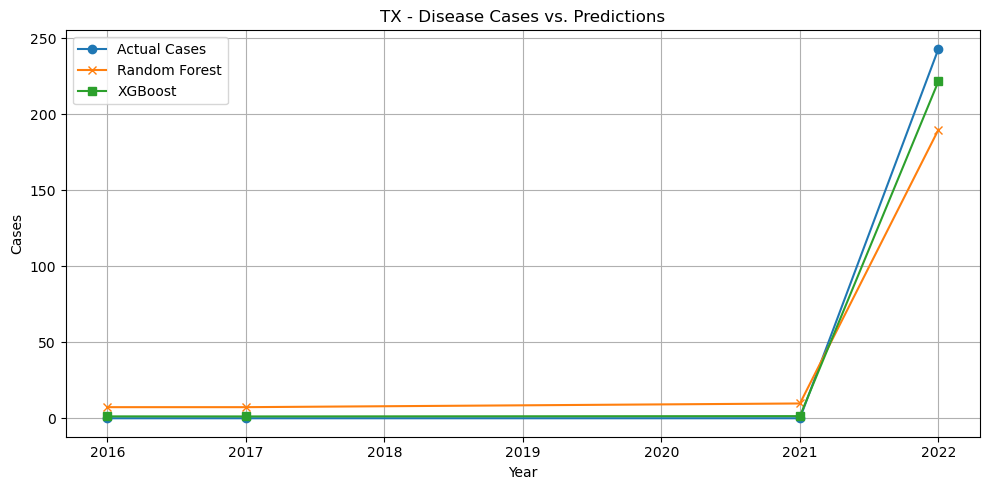

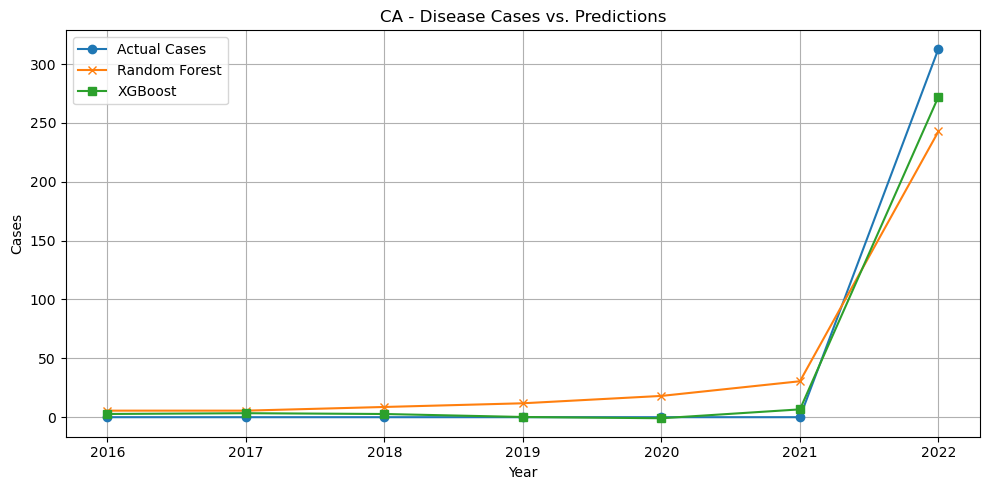

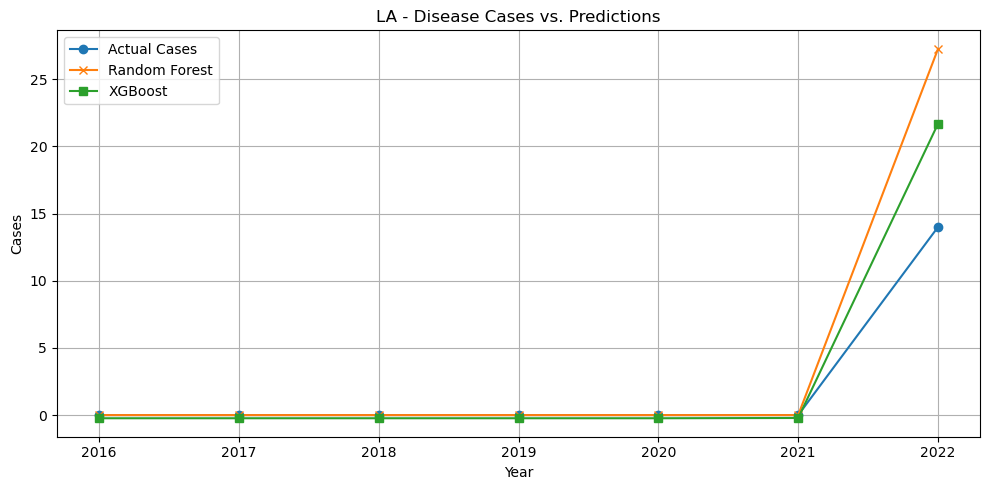

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


# Choose a few states to plot
states_to_plot = ["TX", "CA", "LA"]

# Generate comparison plots
for state in states_to_plot:
    state_data = agg[agg["state"] == state]

    plt.figure(figsize=(10, 5))
    plt.plot(state_data["year"], state_data["cases"], marker='o', label='Actual Cases')
    plt.plot(state_data["year"], state_data["rf_pred"], marker='x', label='Random Forest')
    plt.plot(state_data["year"], state_data["xgb_pred"], marker='s', label='XGBoost')
    plt.title(f"{state} - Disease Cases vs. Predictions")
    plt.xlabel("Year")
    plt.ylabel("Cases")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
